In [1]:
import datautils
import pandas as pd
import modelutils as mu
import nesterov
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import scipy
import itertools
import os
import random

In [2]:
DATASET = "Dataset/ML-CUP23-TR.csv"
RESULTS = "Results/"
PLOT = "Plots/"
RUNS = "FullRuns/"

In [3]:
df_cup = pd.read_csv(DATASET, skiprows=6)
df_cup.rename(columns={"# Training set: ID": "ID"}, inplace=True)

In [4]:
# create test and training sets
DESIGN_SIZE = 0.8
TRAIN_SIZE = 0.8

df_design, df_test = datautils.hold_out(df_cup, DESIGN_SIZE)

assert (
    len(list(set(df_design["ID"]) & set(df_test["ID"]))) == 0
)  # have intersection of cardinality zero

# TODO: Decidere se fare kfold
df_train, df_val = datautils.hold_out(df_design, TRAIN_SIZE)

df_train.info()

X_train, y_train = datautils.obtain_features_targets(df_train)
print(X_train.shape, y_train.shape)

X_val, y_val = datautils.obtain_features_targets(df_val)
print(X_val.shape, y_val.shape)

X_test, y_test = datautils.obtain_features_targets(df_test)
print(X_test.shape, y_test.shape)

input_size = X_train.shape[1]
output_size = y_train.shape[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      640 non-null    int64  
 1   x1      640 non-null    float64
 2   x2      640 non-null    float64
 3   x3      640 non-null    float64
 4   x4      640 non-null    float64
 5   x5      640 non-null    float64
 6   x6      640 non-null    float64
 7   x7      640 non-null    float64
 8   x8      640 non-null    float64
 9   x9      640 non-null    float64
 10  x10     640 non-null    float64
 11  y1      640 non-null    float64
 12  y2      640 non-null    float64
 13  y3      640 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 70.1 KB
(640, 10) (640, 3)
(160, 10) (160, 3)
(200, 10) (200, 3)


In [5]:
# from results dir get all the files, each is a dataframe

# get all the files in the results directory

df_list = []

for file in os.listdir(RESULTS):
    if file.endswith(".csv"):

        curr_df = pd.read_csv(RESULTS + file)
        # if curr df is empty remove file from directory and skip
        if curr_df.empty:
            os.remove(RESULTS + file)
            continue
        # print filenemae and number of columns
        if curr_df.shape[1] != 11:
            continue
        df_list.append(curr_df)

# concatenate all the dataframes
df = pd.concat(df_list)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, 0 to 4
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hidden size          702 non-null    int64  
 1   Mu                   702 non-null    object 
 2   Beta                 702 non-null    object 
 3   Epsilon              702 non-null    float64
 4   Alpha                702 non-null    float64
 5   Seed                 702 non-null    int64  
 6   Initialization type  702 non-null    object 
 7   Train                702 non-null    float64
 8   Validation           702 non-null    float64
 9   Time                 702 non-null    float64
 10  Epochs               702 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 65.8+ KB


In [7]:
# filter for Hidden size == 100
df_100 = df[df["Hidden size"] == 100]

# exclude hidden size 3 and 5
df = df[df["Hidden size"] != 3]
df = df[df["Hidden size"] != 5]

# get all unique values of beta
betas = df["Beta"].unique()
print(betas)

# get tall hidden sizes
hidden_sizes = df["Hidden size"].unique()
print(hidden_sizes)
# get all alpha
alphas = df["Alpha"].unique()
print(alphas)

['schedule' 0.3 0.9 0.6 0 0.99 0.9999 0.999]
[1000   50  100 2000]
[1.e-08 1.e-04 1.e-02 1.e-03 1.e-01 3.e-01 1.e-06]


In [8]:
# reset index df_100
df_100.reset_index(drop=True, inplace=True)
# filter for alpha = 1e-2
df_100 = df_100[df_100["Alpha"] == 1e-2]
df_100.reset_index(drop=True, inplace=True)
df_100

,Hidden size,Mu,Beta,Epsilon,Alpha,Seed,Initialization type,Train,Validation,Time,Epochs
0,100,auto,0.6,0.01,0.01,0,fan-in,24.119105,3.119131,43.737441,788890
1,100,auto,0.6,0.01,0.01,1,fan-in,24.174899,3.435950,47.182648,847087
2,100,auto,0.6,0.01,0.01,2,fan-in,24.164753,3.948172,44.856950,807456
3,100,auto,0.6,0.01,0.01,3,fan-in,24.324993,3.965440,45.309389,820273
4,100,auto,0.6,0.01,0.01,4,fan-in,24.388268,3.566467,47.471158,856809
...,...,...,...,...,...,...,...,...,...,...,...
110,100,col,0.6,0.01,0.01,0,fan-in,24.119104,3.119131,45.018097,788890
111,100,col,0.6,0.01,0.01,1,fan-in,24.174900,3.435951,48.465834,847086
112,100,col,0.6,0.01,0.01,2,fan-in,24.164752,3.948172,46.589876,807455
113,100,col,0.6,0.01,0.01,3,fan-in,24.324994,3.965440,46.883423,820272


In [9]:
# filter for mu auto
df_auto = df_100[df_100["Mu"] == "auto"]
df_auto.reset_index(drop=True, inplace=True)

#  f"{RUNS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}_{seed}.pkl",

# now retrieve all the relative runs
runs = {}

# for value of beta
for beta in betas:
    # retrieve all runs with respective values of beta
    for file in os.listdir(RUNS):
        if file.startswith(f"ELM_100_auto_{beta}_0.01_0.01"):
            print(file)
            with open(RUNS + file, "rb") as f:
                seed = int(file.split("_")[-1].split(".")[0])
                runs[(beta, seed)] = pickle.load(f)

ELM_100_auto_schedule_0.01_0.01_4.pkl
ELM_100_auto_schedule_0.01_0.01_3.pkl
ELM_100_auto_schedule_0.01_0.01_2.pkl
ELM_100_auto_schedule_0.01_0.01_0.pkl
ELM_100_auto_schedule_0.01_0.01_1.pkl
ELM_100_auto_0.3_0.01_0.01_4.pkl
ELM_100_auto_0.3_0.01_0.01_1.pkl
ELM_100_auto_0.3_0.01_0.01_0.pkl
ELM_100_auto_0.3_0.01_0.01_2.pkl
ELM_100_auto_0.3_0.01_0.01_3.pkl
ELM_100_auto_0.9_0.01_0.01_0.pkl
ELM_100_auto_0.9_0.01_0.01_1.pkl
ELM_100_auto_0.9_0.01_0.01_3.pkl
ELM_100_auto_0.9_0.01_0.01_2.pkl
ELM_100_auto_0.9_0.01_0.01_4.pkl
ELM_100_auto_0.6_0.01_0.01_2.pkl
ELM_100_auto_0.6_0.01_0.01_3.pkl
ELM_100_auto_0.6_0.01_0.01_1.pkl
ELM_100_auto_0.6_0.01_0.01_0.pkl
ELM_100_auto_0.6_0.01_0.01_4.pkl
ELM_100_auto_0_0.01_0.01_3.pkl
ELM_100_auto_0_0.01_0.01_2.pkl
ELM_100_auto_0_0.01_0.01_0.pkl
ELM_100_auto_0_0.01_0.01_1.pkl
ELM_100_auto_0_0.01_0.01_4.pkl
ELM_100_auto_0.99_0.01_0.01_3.pkl
ELM_100_auto_0.99_0.01_0.01_2.pkl
ELM_100_auto_0.99_0.01_0.01_0.pkl
ELM_100_auto_0.99_0.01_0.01_1.pkl
ELM_100_auto_0.99_0.01_0

[np.float64(24.0954), np.float64(24.1514), np.float64(24.1497), np.float64(24.3124), np.float64(24.3591)]


IndexError: list index out of range

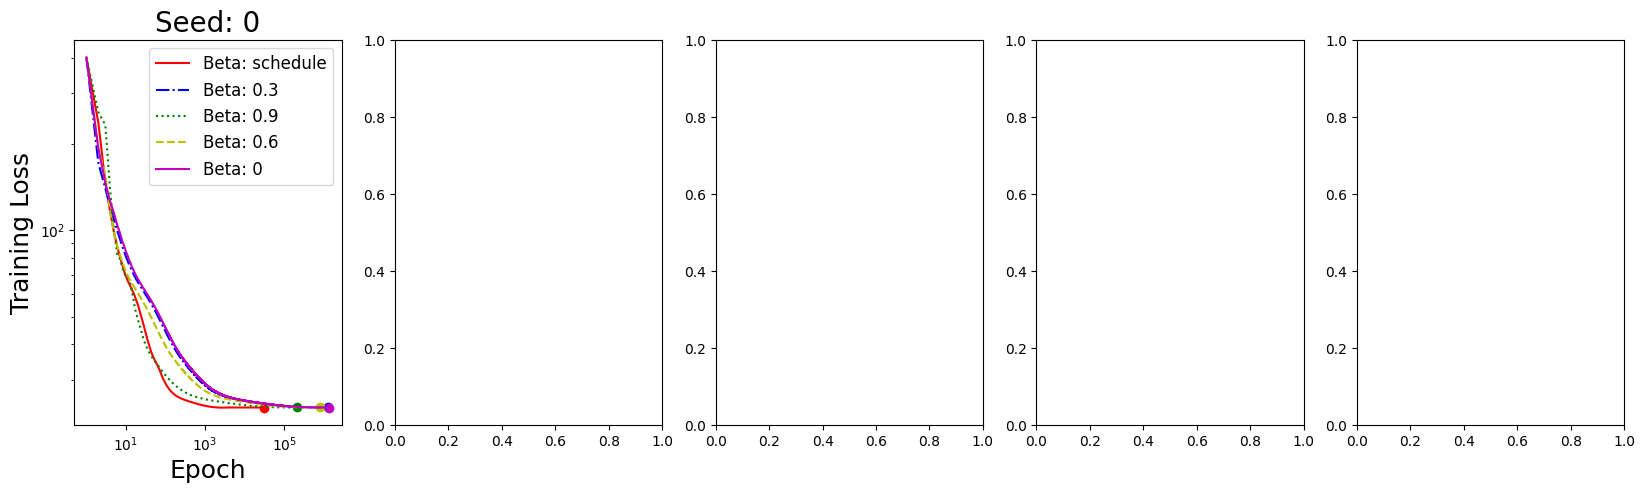

In [10]:
# now plot the training curve for each run found

# get the minimum training value across all runs
min_train_list = [np.inf] * 5

# list of styles for each beta in plot (with different line and color) with 5 styles

styles = ["r-", "b-.", "g:", "y--", "m-"]


fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for seed in range(5):
    ax = axs[seed]

    for key, run in runs.items():
        if key[1] == seed:
            ax.plot(
                np.arange(1, len(run["loss_train_history"]) + 1),
                run["loss_train_history"],
                styles[betas.tolist().index(key[0])],
                label=f"Beta: {key[0]}",
            )
            ax.scatter(
                len(run["loss_train_history"]),
                run["loss_train_history"][-1],
                color=styles[betas.tolist().index(key[0])][0],
            )
            ax.set_xlabel("Epoch", fontsize=18)
            if seed == 0:
                ax.set_ylabel("Training Loss", fontsize=18)
            ax.set_xscale("log", base=10)
            ax.set_yscale("log")
            ax.set_title(f"Seed: {seed}", fontsize=20)
            ax.legend(fontsize=12)

fig.suptitle("Training Loss for different seeds", fontsize=24)

plt.tight_layout()
plt.show()

# TODO:usa solo trailnew

In [11]:
# load runs for initializations experiments

init_runs = {}

for file in os.listdir(RUNS):
    if file.startswith("std") or file.startswith("fan-in"):
        print(file)
        with open(RUNS + file, "rb") as f:
            seed = int(file.split("_")[-1].split(".")[0])
            init = file.split("_")[0]
            init_runs[(init, seed)] = pickle.load(f)

std_5.pkl
fan-in_5.pkl
fan-in_4.pkl
std_4.pkl
std_6.pkl
fan-in_6.pkl
fan-in_7.pkl
std_7.pkl
std_3.pkl
fan-in_3.pkl
fan-in_2.pkl
std_2.pkl
std_0.pkl
fan-in_0.pkl
fan-in_1.pkl
std_1.pkl
std_9.pkl
fan-in_9.pkl
fan-in_8.pkl
std_8.pkl


In [12]:
# for each type of initialization, print the seed of best,worst and median run, based on final training value
min_train_dict = {}
for key, run in init_runs.items():
    min_train_dict[key] = min(run["loss_train_history"])


# ontain two list, one for each type of initialization
std_list = [0] * 10
fan_in_list = [0] * 10

for key, value in min_train_dict.items():
    if key[0] == "std":
        std_list[key[1]] = value
    else:
        fan_in_list[key[1]] = value

# obtain inidices of the sorted list
std_sorted = np.argsort(std_list)
fan_in_sorted = np.argsort(fan_in_list)

print(std_sorted)
print(fan_in_sorted)

[4 8 5 3 9 0 1 2 7 6]
[9 8 1 7 4 3 5 2 0 6]


In [13]:
# in df, filter for each hidden size
# for each hidden size, filter for their respective alpha

df_sizes = []

for size in hidden_sizes:
    print(size)
    df_sizes.append(df[df["Hidden size"] == size])

# for each size, filter for their specific alpha
df_sizes[0] = df_sizes[0][df_sizes[0]["Alpha"] == 1e-2]
df_sizes[1] = df_sizes[1][df_sizes[1]["Alpha"] == 1e-8]
df_sizes[2] = df_sizes[2][df_sizes[2]["Alpha"] == 1e-2]
df_sizes[3] = df_sizes[3][df_sizes[3]["Alpha"] == 1e-2]

1000
50
100
2000


In [14]:
# for each df print values of mu and beta

for df_size in df_sizes:
    print(df_size["Mu"].unique(), df_size["Beta"].unique())

[1e-05 'col' 'auto'] ['schedule']
['auto' 0.0001 'col'] ['schedule' 0.3 0.9 0.99 0 0.6]
['auto' 0.0001 'col'] [0.6 'schedule' 0.3 0 0.9 0.99 0.9999 0.999]
[1e-06 'auto' 'col'] ['schedule']


In [28]:
beta = "schedule"
mu_list = ["auto", "col", 0.0001, 1e-5, 1e-6]

times_dict = {}

# for each mu, obtain for each size average num of iterations and time
for mu in mu_list:
    for idx, df_s in enumerate(df_sizes):

        df_beta = df_s[df_s["Beta"] == beta]
        df_mu = df_beta[df_beta["Mu"] == mu]

        if len(df_mu["Hidden size"].unique()) == 0:
            continue

        # for each seed maintain only the lowest time
        df_mu = df_mu.groupby("Seed").min().reset_index()
        print(df_mu.shape)

        avg_iter = df_mu["Epochs"].mean()
        avg_time = df_mu["Time"].mean()
        avg_loss = df_mu["Train"].mean()

        print(
            f"Hidden size: {df_mu['Hidden size'].unique()} Mu: {mu} Beta: {beta} Avg Iterations: {avg_iter} Avg Time: {avg_time} Avg Loss: {avg_loss}"
        )

        if mu != "auto" and mu != "col":
            times_dict[(df_mu["Hidden size"].unique()[0], "other")] = (
                avg_iter,
                avg_time,
                avg_loss,
            )
        else:
            times_dict[(df_mu["Hidden size"].unique()[0], mu)] = (
                avg_iter,
                avg_time,
                avg_loss,
            )

(5, 11)
Hidden size: [1000] Mu: auto Beta: schedule Avg Iterations: 78431.4 Avg Time: 40.48810160000012 Avg Loss: 22.414921309728392
(5, 11)
Hidden size: [50] Mu: auto Beta: schedule Avg Iterations: 17824.4 Avg Time: 0.32913000000044124 Avg Loss: 7.379537428116459
(5, 11)
Hidden size: [100] Mu: auto Beta: schedule Avg Iterations: 32584.0 Avg Time: 1.8502153999997972 Avg Loss: 24.233691864525507
(5, 11)
Hidden size: [2000] Mu: auto Beta: schedule Avg Iterations: 98634.2 Avg Time: 461.1015488 Avg Loss: 22.371127574265167
(5, 11)
Hidden size: [1000] Mu: col Beta: schedule Avg Iterations: 78429.6 Avg Time: 41.10738199999996 Avg Loss: 22.414921246380352
(5, 11)
Hidden size: [50] Mu: col Beta: schedule Avg Iterations: 17823.6 Avg Time: 0.37548700000006646 Avg Loss: 7.379537430017939
(5, 11)
Hidden size: [100] Mu: col Beta: schedule Avg Iterations: 32582.4 Avg Time: 0.8843809999998484 Avg Loss: 24.233692209083962
(5, 11)
Hidden size: [2000] Mu: col Beta: schedule Avg Iterations: 98632.8 Avg T

auto
[np.float64(17824.4), np.float64(32584.0), np.float64(78431.4), np.float64(98634.2)]
[np.float64(0.32913000000044124), np.float64(1.8502153999997972), np.float64(40.48810160000012), np.float64(461.1015488)]
col
[np.float64(17823.6), np.float64(32582.4), np.float64(78429.6), np.float64(98632.8)]
[np.float64(0.37548700000006646), np.float64(0.8843809999998484), np.float64(41.10738199999996), np.float64(456.38855159999986)]
other
[np.float64(30871.6), np.float64(34124.2), np.float64(82591.0), np.float64(246321.2)]
[np.float64(0.39629620000014254), np.float64(0.6013983999999255), np.float64(37.74801459999999), np.float64(933.2462853999999)]


Text(0.5, 1.0, 'Average Time for different Hidden Sizes')

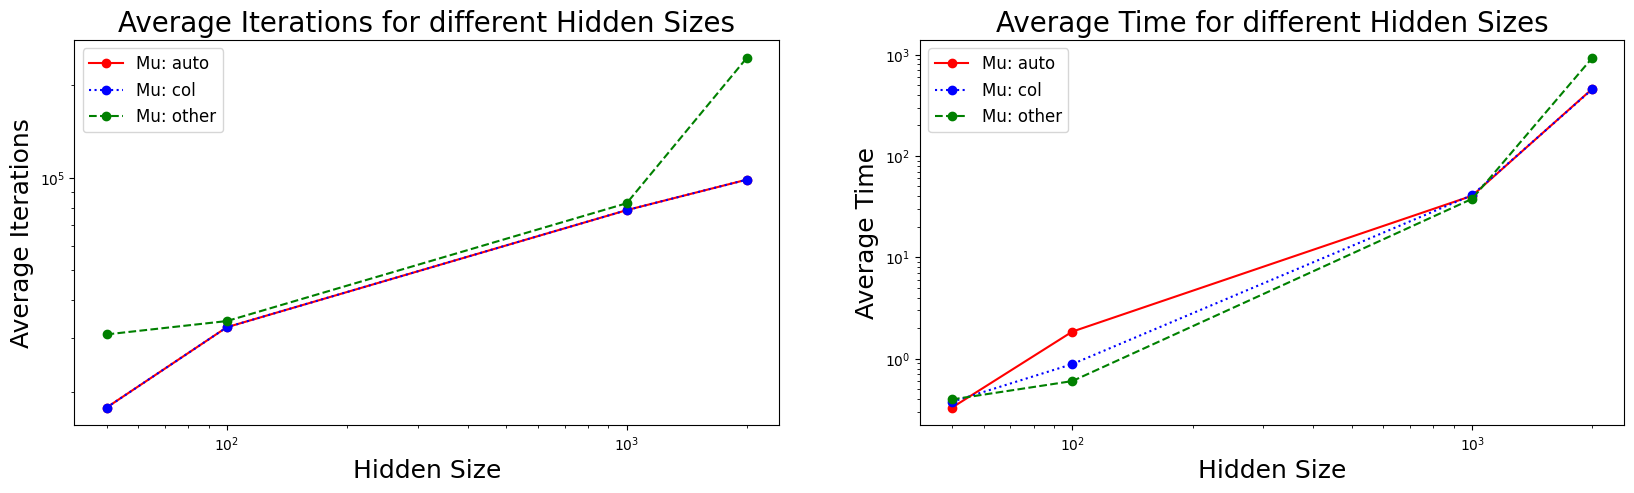

In [29]:
# now plot, for each mu, the average number of iterations and time for each hidden size

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# create 3 styles for the plot
styles = ["r-", "b:", "g--"]

# keep track of minimum for time plto
min_time_list = [np.inf] * 4
min_loss_list = [np.inf] * 4

for idx, mu in enumerate(["auto", "col", "other"]):

    print(mu)
    size_list = []
    avg_iter_list = []
    avg_time_list = []
    avg_loss_list = []

    for size in sorted(hidden_sizes):
        if (size, mu) in times_dict:
            avg_iter_list.append(times_dict[(size, mu)][0])
            avg_time_list.append(times_dict[(size, mu)][1])
            avg_loss_list.append(times_dict[(size, mu)][2])
        else:
            raise ValueError(
                f"Hidden size {size} and mu {mu} not found in times_dict"
            )

    min_time_list = [min(min_time_list[i], avg_time_list[i]) for i in range(4)]
    min_loss_list = [min(min_loss_list[i], avg_loss_list[i]) for i in range(4)]

    print(avg_iter_list)
    print(avg_time_list)
    ax = axs[0]
    ax.plot(
        sorted(hidden_sizes),
        avg_iter_list,
        styles[idx],
        label=f"Mu: {mu}",
        marker="o",
    )
    ax.set_xlabel("Hidden Size", fontsize=18)
    ax.set_ylabel("Average Iterations", fontsize=18)
    ax.set_xscale("log")
    ax.legend(fontsize=12)

    ax = axs[1]
    ax.plot(
        sorted(hidden_sizes),
        avg_time_list,
        styles[idx],
        label=f"Mu: {mu}",
        marker="o",
    )
    ax.set_xlabel("Hidden Size", fontsize=18)
    ax.set_ylabel("Average Time", fontsize=18)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(fontsize=12)

    # put plot title
axs[0].set_title("Average Iterations for different Hidden Sizes", fontsize=20)
axs[0].set_yscale("log")
axs[1].set_title("Average Time for different Hidden Sizes", fontsize=20)

In [17]:
# for each value of alpha, obtain the average number of iterations for each hidden size
# use mu = auto and beta = schedule
df_filtered = df[(df["Mu"] == "auto") & (df["Beta"] == 0)]
alphas = [1.0e-08, 1.0e-04, 1.0e-01, 1.0e-02, 3.0e-01, 1.0e-06]
print(alphas)

times_dict = {}
epochs_dict = {}

for alpha in alphas:
    df_alpha = df_filtered[df_filtered["Alpha"] == alpha].reset_index(
        drop=True
    )
    print("\nalpha", alpha)
    grouped = df_alpha.groupby("Hidden size")[["Epochs", "Time"]].mean()

    for size in hidden_sizes:
        if size in grouped.index:
            times_dict[(size, alpha)] = grouped.loc[size]["Time"]
            epochs_dict[(size, alpha)] = grouped.loc[size]["Epochs"]
        else:
            print(f"Hidden size {size} not found in df_alpha")

[1e-08, 0.0001, 0.1, 0.01, 0.3, 1e-06]

alpha 1e-08
Hidden size 2000 not found in df_alpha

alpha 0.0001
Hidden size 2000 not found in df_alpha

alpha 0.1
Hidden size 1000 not found in df_alpha
Hidden size 2000 not found in df_alpha

alpha 0.01
Hidden size 1000 not found in df_alpha
Hidden size 2000 not found in df_alpha

alpha 0.3
Hidden size 1000 not found in df_alpha
Hidden size 2000 not found in df_alpha

alpha 1e-06
Hidden size 1000 not found in df_alpha
Hidden size 2000 not found in df_alpha


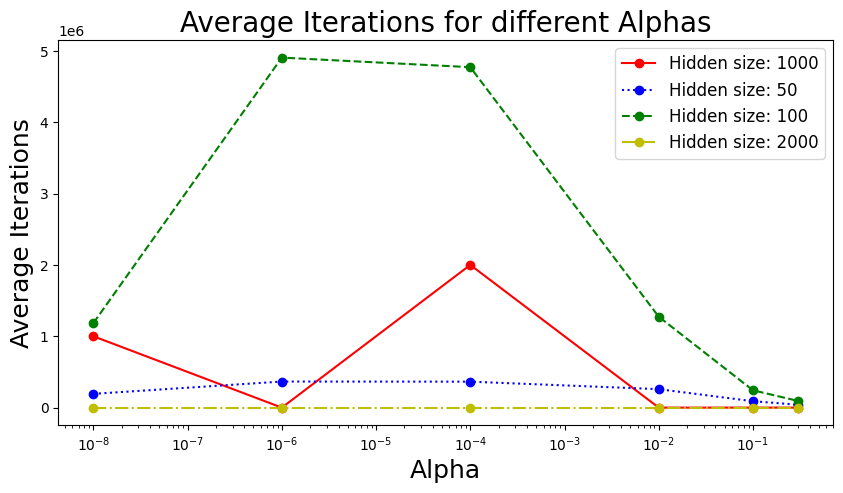

In [18]:
# plot for each alpha the average number of iterations for each hidden size, all in the same plot
from collections import defaultdict

epochs_dict = defaultdict(int, epochs_dict)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

styles = ["r-", "b:", "g--", "y-.", "m--", "c-"]

for idx, hidden in enumerate(hidden_sizes):
    avg_iter_list = [0] * len(alphas)
    for alpha in alphas:
        avg_iter_list[alphas.index(alpha)] = epochs_dict[(hidden, alpha)]

    # reorder values in list based on alpha
    avg_iter_list = [x for _, x in sorted(zip(alphas, avg_iter_list))]

    axs.plot(
        sorted(alphas),
        avg_iter_list,
        styles[idx],
        label=f"Hidden size: {hidden}",
        marker="o",
    )
    axs.set_xlabel("Alpha", fontsize=18)
    axs.set_ylabel("Average Iterations", fontsize=18)
    axs.set_xscale("log")
    axs.legend(fontsize=12)
    axs.set_title("Average Iterations for different Alphas", fontsize=20)

50
ELM_50_auto_schedule_1e-08_0.01_2.pkl
Overfitting
Overfitting
Overfitting
Overfitting
Seed 2
Validation Loss [np.float64(7.550136980760636), np.float64(7.550132710280029)]
Overfitting
100
ELM_100_auto_schedule_0.01_0.01_4.pkl
Overfitting
Overfitting
Overfitting
Overfitting
Seed 4
Validation Loss [np.float64(3.4349780675751758), np.float64(3.434978132305166)]
Overfitting
1000
Overfitting
Overfitting
ELM_1000_auto_schedule_0.01_0.01_0.pkl
Overfitting
Overfitting
Seed 0
Validation Loss [np.float64(0.676674333442161), np.float64(0.6766743511687265)]
Overfitting
2000
Overfitting
Overfitting
Overfitting
ELM_2000_auto_schedule_0.01_0.01_0.pkl
Overfitting
Seed 0
Validation Loss [np.float64(0.5807687211387522), np.float64(0.5807682849491264)]
Overfitting


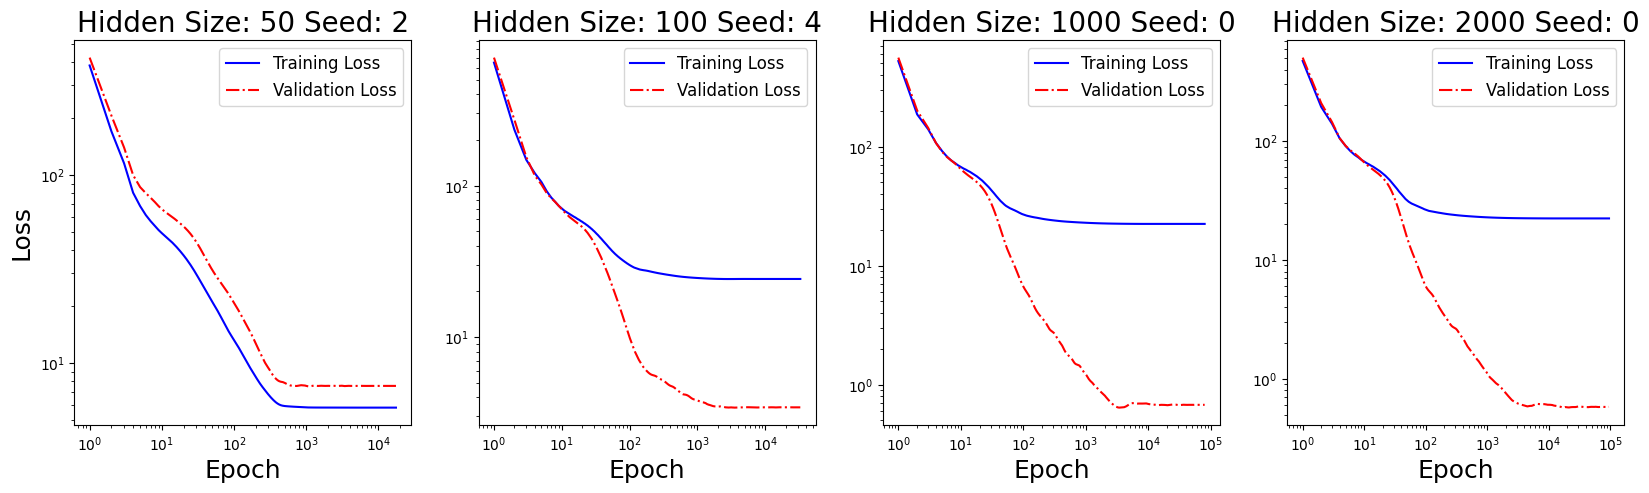

In [19]:
# for each hidden size, with right alpha, with mu = auto and beta = schedule, search which seed has highest training loss

df_filtered = df[(df["Mu"] == "auto") & (df["Beta"] == "schedule")]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))


# for each hidden size, filter for their respective alpha
for idx, size in enumerate(sorted(hidden_sizes)):
    print(size)
    df_size = df_filtered[df_filtered["Hidden size"] == size]

    if size == 50:
        alpha = 1e-8
    else:
        alpha = 1e-2

    df_alpha = df_size[df_size["Alpha"] == alpha]

    # sort by training loss
    seed = (
        df_alpha.sort_values(by="Train", ascending=False)
        .head(1)["Seed"]
        .values[0]
    )

    # recore the full run for this seed
    for file in os.listdir(RUNS):
        if file.startswith(f"ELM_{size}_auto_schedule_{alpha}_0.01_"):
            if int(file.split("_")[-1].split(".")[0]) == seed:
                print(file)
                with open(RUNS + file, "rb") as f:
                    run = pickle.load(f)

            else:
                # open the run, check last two element of validation to see if overfitting
                with open(RUNS + file, "rb") as f:
                    run = pickle.load(f)
                    val_loss = run["loss_val_history"]
                    if val_loss[-1] > min(val_loss[:-1]):
                        print("Overfitting")
                    else:
                        print("AAAAAA")
                        print("Not Overfitting")

    # now check if the run is overfitting, by looking at the validation loss in the last 2 epochs
    val_loss = run["loss_val_history"]
    print("Seed", seed)
    print("Validation Loss", val_loss[-2:])

    if val_loss[-1] > min(val_loss[:-1]):
        print("Overfitting")
    else:
        print("Not Overfitting")

    # now plot the run

    axs[idx].plot(
        np.arange(1, len(run["loss_train_history"]) + 1),
        run["loss_train_history"],
        "b-",
        label="Training Loss",
    )
    axs[idx].plot(
        np.arange(1, len(run["loss_val_history"]) + 1),
        run["loss_val_history"],
        "r-.",
        label="Validation Loss",
    )
    axs[idx].set_xlabel("Epoch", fontsize=18)
    if idx == 0:
        axs[idx].set_ylabel("Loss", fontsize=18)
    axs[idx].set_xscale("log")
    axs[idx].set_yscale("log")
    axs[idx].legend(fontsize=12)
    axs[idx].set_title(f"Hidden Size: {size} Seed: {seed}", fontsize=20)

In [20]:
# from results obtain all files containing "trialnew1"

df_list = []

for file in os.listdir(RESULTS):
    if "trialnew1" in file:
        curr_df = pd.read_csv(RESULTS + file)
        # if curr df is empty remove file from directory and skip
        if curr_df.empty:
            os.remove(RESULTS + file)
            continue
        # print filenemae and number of columns
        if curr_df.shape[1] != 11:
            continue
        df_list.append(curr_df)

# concatenate all the dataframes
df = pd.concat(df_list)
df = df[df["Hidden size"] == 100]
df

,Hidden size,Mu,Beta,Epsilon,Alpha,Seed,Initialization type,Train,Validation,Time,Epochs
0,100,auto,0.3,0.01,0.01,0,fan-in,24.119048,3.119076,70.103894,1251109
1,100,auto,0.3,0.01,0.01,1,fan-in,24.174848,3.435877,75.462984,1343286
2,100,auto,0.3,0.01,0.01,2,fan-in,24.164713,3.948051,71.629355,1281112
3,100,auto,0.3,0.01,0.01,3,fan-in,24.324949,3.965428,73.291380,1301264
4,100,auto,0.3,0.01,0.01,4,fan-in,24.388218,3.566407,76.325488,1359250
0,100,auto,0.99,0.01,0.01,0,fan-in,24.119139,3.119168,1.237710,20930
1,100,auto,0.99,0.01,0.01,1,fan-in,24.174932,3.436016,1.327534,22494
2,100,auto,0.99,0.01,0.01,2,fan-in,24.164777,3.948250,1.282887,21436
3,100,auto,0.99,0.01,0.01,3,fan-in,24.325021,3.965458,1.300491,21781
4,100,auto,0.99,0.01,0.01,4,fan-in,24.388300,3.566496,1.356784,22764


ELM_100_auto_0.3_0.01_0.01_0.pkl
ELM_100_auto_0.3_0.01_0.01_1.pkl
ELM_100_auto_0.3_0.01_0.01_2.pkl
ELM_100_auto_0.3_0.01_0.01_3.pkl
ELM_100_auto_0.3_0.01_0.01_4.pkl
ELM_100_auto_0.99_0.01_0.01_0.pkl
ELM_100_auto_0.99_0.01_0.01_1.pkl
ELM_100_auto_0.99_0.01_0.01_2.pkl
ELM_100_auto_0.99_0.01_0.01_3.pkl
ELM_100_auto_0.99_0.01_0.01_4.pkl
ELM_100_auto_0.9999_0.01_0.01_0.pkl
ELM_100_auto_0.9999_0.01_0.01_1.pkl
ELM_100_auto_0.9999_0.01_0.01_2.pkl
ELM_100_auto_0.9999_0.01_0.01_3.pkl
ELM_100_auto_0.9999_0.01_0.01_4.pkl
ELM_100_auto_0.999_0.01_0.01_0.pkl
ELM_100_auto_0.999_0.01_0.01_1.pkl
ELM_100_auto_0.999_0.01_0.01_2.pkl
ELM_100_auto_0.999_0.01_0.01_3.pkl
ELM_100_auto_0.999_0.01_0.01_4.pkl
ELM_100_auto_0_0.01_0.01_0.pkl
ELM_100_auto_0_0.01_0.01_1.pkl
ELM_100_auto_0_0.01_0.01_2.pkl
ELM_100_auto_0_0.01_0.01_3.pkl
ELM_100_auto_0_0.01_0.01_4.pkl
ELM_100_auto_schedule_0.01_0.01_0.pkl
ELM_100_auto_schedule_0.01_0.01_1.pkl
ELM_100_auto_schedule_0.01_0.01_2.pkl
ELM_100_auto_schedule_0.01_0.01_3.pkl
ELM

Text(0.5, 0.98, 'Training Loss for different seeds')

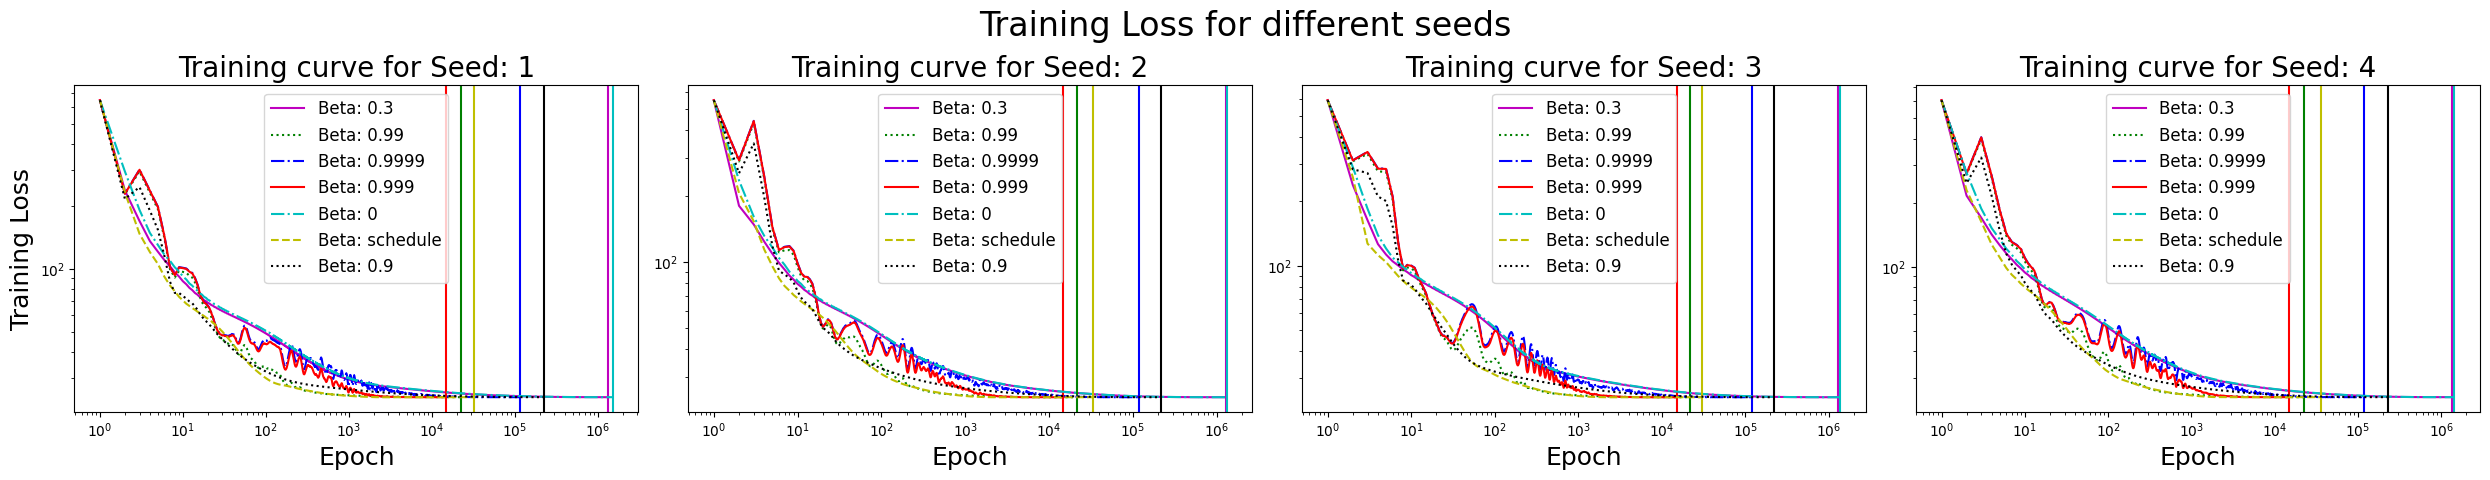

In [22]:
# for each seed plot, for each value of beta, the training loss

# get all the unique values of beta
betas = df["Beta"].unique()

# get all the unique values of seed
seeds = df["Seed"].unique()

# get all the relative runs

runs = {}

for beta in betas:
    for seed in seeds:
        for file in os.listdir(RUNS):
            if file.startswith(f"ELM_100_auto_{beta}_0.01_0.01_{seed}"):
                print(file)
                with open(RUNS + file, "rb") as f:
                    runs[(beta, seed)] = pickle.load(f)


# now plot the training curve for each run found
fig, axs = plt.subplots(1, 4, figsize=(25, 5))

# define 7 style
styles = ["r-", "b-.", "g:", "y--", "m-", "c-.", "k:"]
random.seed(0)
random.shuffle(styles)

for idx, seed in enumerate([1, 2, 3, 4]):

    ax = axs[idx]

    for beta in betas:
        run = runs[(beta, seed)]
        ax.plot(
            np.arange(1, len(run["loss_train_history"]) + 1),
            run["loss_train_history"],
            styles[betas.tolist().index(beta)],
            label=f"Beta: {beta}",
        )
        """ax.scatter(
            len(run["loss_train_history"]),
            run["loss_train_history"][-1],
        )"""
        # plot vertical line at final epoch
        ax.axvline(
            x=len(run["loss_train_history"]),
            color=styles[betas.tolist().index(beta)][0],
            linestyle="-",
        )
        ax.set_xlabel("Epoch", fontsize=18)
        if idx == 0:
            ax.set_ylabel("Training Loss", fontsize=18)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(f"Training curve for Seed: {seed}", fontsize=20)
        ax.legend(fontsize=12)

fig.tight_layout(rect=[0, 0.03, 1, 0.92])
fig.suptitle("Training Loss for different seeds", fontsize=24)

In [23]:
# for each beta, sort the seeds by lowest training loss

for beta in betas:
    seed_list = []
    for seed in seeds:
        run = runs[(beta, seed)]
        seed_list.append((seed, min(run["loss_train_history"])))

    seed_list = sorted(seed_list, key=lambda x: x[1])

    print(f"Beta: {beta}")
    print([int(seed[0]) for seed in seed_list])

Beta: 0.3
[0, 2, 1, 3, 4]
Beta: 0.99
[0, 2, 1, 3, 4]
Beta: 0.9999
[0, 2, 1, 3, 4]
Beta: 0.999
[0, 2, 1, 3, 4]
Beta: 0
[0, 2, 1, 3, 4]
Beta: schedule
[0, 2, 1, 3, 4]
Beta: 0.9
[0, 2, 1, 3, 4]


In [ ]:
# obtain training loss for each seed
min_train_list = [np.inf] * 5

   Hidden size  Alpha  Seed Initialization type      Train  Validation  \
0         2000   0.01     0              fan-in  22.371902    0.676390   
1         2000   0.01     1              fan-in  22.371844    0.580133   
2         2000   0.01     2              fan-in  22.371545    0.660068   
3         2000   0.01     3              fan-in  22.370764    0.741406   
4         2000   0.01     4              fan-in  22.369472    0.757372   
5         2000   0.01     5              fan-in  22.370225    0.634120   
6         2000   0.01     6              fan-in  22.374191    0.715082   
7         2000   0.01     7              fan-in  22.370093    0.709698   
8         2000   0.01     8              fan-in  22.366694    0.687531   
9         2000   0.01     9              fan-in  22.368782    0.614162   

       Time  
0  5.298926  
1  5.257739  
2  5.281107  
3  5.255893  
4  5.285460  
5  5.290025  
6  5.308415  
7  5.289961  
8  5.297433  
9  5.375691  
   Hidden size  Alpha  Seed Ini

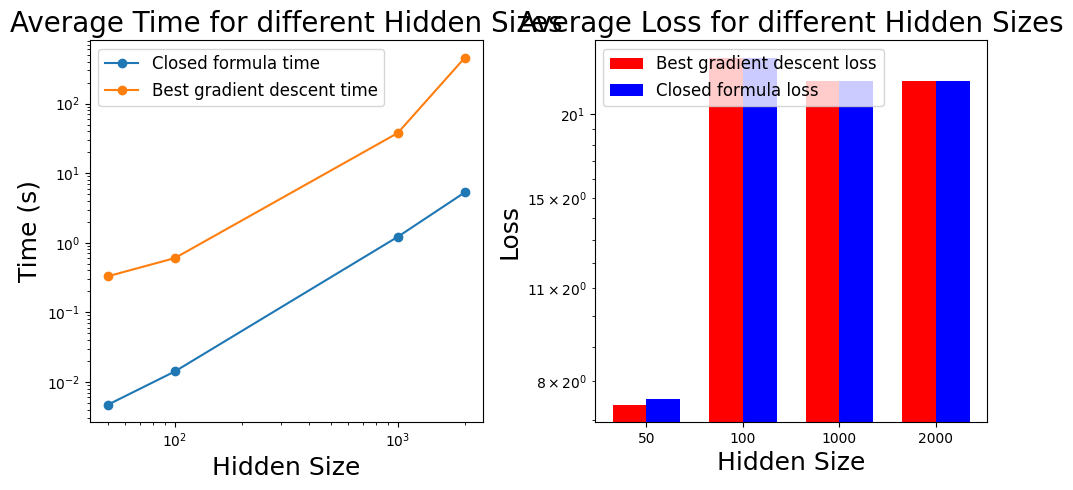

In [42]:
# get .csv of system resolution with cholesky

dfs = {50: None, 100: None, 1000: None, 2000: None}


for filename in os.listdir(RESULTS):
    if "sysres" in filename:
        sysres = pd.read_csv(RESULTS + filename)
        print(sysres)
        hidden_size = int(filename.split("_")[1])
        dfs[hidden_size] = sysres

# for each df, plot average training time

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

x_ax = [50, 100, 1000, 2000]
y_ax = []
y_ax_loss = []
for hidden_size, df in dfs.items():

    if df is not None:
        avg_time = df["Time"].mean()
        y_ax.append(avg_time)
        avg_loss = df["Train"].mean()
        y_ax_loss.append(avg_loss)

print(y_ax_loss)

axs[0].plot(x_ax, y_ax, marker="o", label="Closed formula time")
axs[0].plot(
    x_ax, min_time_list, marker="o", label="Best gradient descent time"
)
axs[0].set_xlabel("Hidden Size", fontsize=18)
axs[0].set_ylabel("Time (s)", fontsize=18)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].legend(fontsize=12)
axs[0].set_title("Average Time for different Hidden Sizes", fontsize=20)

true_ax = np.arange(1, 5)
# Create a grouped bar plot for the losses
bar_width = 0.35
index = np.arange(len(true_ax))

bar1 = axs[1].bar(index, min_loss_list, bar_width, label="Best gradient descent loss", color="r")
bar2 = axs[1].bar(index + bar_width, y_ax_loss, bar_width, label="Closed formula loss", color="b")

axs[1].set_xlabel("Hidden Size", fontsize=18)
axs[1].set_ylabel("Loss", fontsize=18)
axs[1].set_yscale("log",base=20)
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(x_ax)
axs[1].legend(fontsize=12)
axs[1].set_title("Average Loss for different Hidden Sizes", fontsize=20)

fig.tight_layout()

print(min_loss_list)
print(y_ax_loss)